# Resolve Population and water use inconsistency

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
#import geopandas
#from ipyleaflet import Map, GeoData, basemaps, LayersControl
#import contextily as cx

In [12]:
%matplotlib widget
%matplotlib inline
%matplotlib ipympl

In [4]:
xx = 1

In [4]:
# uitls
def inf_to_nan(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

## Files with information about population
* swud_df15: is annual (and some monthly) water use data from SWUD15. Columns with population info are:
    - POP_SRV: population served
    - POP_METH: method of population estimation. Method is not clear

* swud_df16: is annual (and some monthly) water use data from SWUD16. Columns with population info are:
    - POP_SRV: population served
    - POP_METH: method of population estimation. Method is not clear
* wsa_v1: is the population in the service area shapefile. It also has the total and poly population
* wsa_local_pop: this population information that is provided by Cheryl

In [5]:
db_root = r"C:\work\water_use\mldataset"
swud_df15 = pd.read_csv(os.path.join(db_root, r"ml\training\targets\monthly_annually\swud_v15.csv"), encoding='cp1252')
swud_df16 = pd.read_csv(os.path.join(db_root,
                                     r"ml\training\targets\monthly_annually\SWUDS v16 WDs by FROM-sites and by WSA_AGG_ID_04282021.csv"),
                                     encoding='cp1252')
wsa_v1 = pd.read_csv(os.path.join(db_root, r"ml\training\misc_features\WSA_V1_fromCheryl.csv"))
wsa_local_pop = pd.read_excel(
    r"C:\work\water_use\mldataset\ml\training\misc_features\V1_polys_with_water_service_08072021_for_Ayman_popsrv_year.xlsx")

C:\Miniconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (12,20,65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
config = configparser.ConfigParser()
config_file = r"C:\work\water_use\ml_experiments\annual_v_0_0\config_file.ini"
config.read(config_file)

# get variable names
workspace = config.get("Files", "Workspace")
train_file = config.get("Files", "Train_file")
target = config.get("Target", "target_field")

# read files
df_main = pd.read_csv(train_file)
df_train = df_main[df_main['wu_rate'] > 0]


C:\Miniconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (163) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
sys_id = set(swud_df15['WSA_AGIDF']).union(set(swud_df16['WSA_AGIDF']))
sys_id = sys_id.union(wsa_v1['WSA_AGIDF'])

master_pop_df = pd.DataFrame()
master_pop_df['WSA_AGIDF'] = list(sys_id)

# add swud15
sw15 = swud_df15[['WSA_AGIDF', 'POP_SRV']]
sw15 = sw15.groupby(by=['WSA_AGIDF']).mean().reset_index()
master_pop_df = master_pop_df.merge(sw15, how='left', right_on='WSA_AGIDF', left_on='WSA_AGIDF')
master_pop_df['pop_swud15'] = master_pop_df['POP_SRV']
del (master_pop_df['POP_SRV'])
del (sw15)

# add swud16
sw16 = swud_df16[['WSA_AGIDF', 'POP_SRV']]
sw16 = sw16.groupby(by=['WSA_AGIDF']).mean().reset_index()
master_pop_df = master_pop_df.merge(sw16, how='left', right_on='WSA_AGIDF', left_on='WSA_AGIDF')
master_pop_df['pop_swud16'] = master_pop_df['POP_SRV']
del (master_pop_df['POP_SRV'])
del (sw16)

# add wsa_v1
wsav1 = wsa_v1[['WSA_AGIDF', 'WSA_SQKM', 'TPOLYPOP', 'TPOPSRV']]
wsav1 = wsav1.groupby(by=['WSA_AGIDF']).mean().reset_index()
master_pop_df = master_pop_df.merge(wsav1, how='left', right_on='WSA_AGIDF', left_on='WSA_AGIDF')

# add wsa_local_pop
wsa_local = wsa_local_pop[['WSA_AGIDF', 'POP_SRV', 'POP_METH']].copy()


def extrat_year(txt):
    new_string = ''
    for s in txt:
        if s.isdigit():
            new_string = new_string + s
        else:
            new_string = new_string + " "

    years = new_string.strip().split()
    years = [int(y) for y in years]
    years = np.array(years)
    years = years[years > 1000]
    year = np.mean(years)
    if pd.isna(year):
        return 2013
    else:
        return int(year)


wsa_local['local_year'] = wsa_local['POP_METH'].apply(extrat_year)
del (wsa_local['POP_METH'])
wsa_local = wsa_local.groupby(by=['WSA_AGIDF']).mean().reset_index()
master_pop_df = master_pop_df.merge(wsa_local, how='left', right_on='WSA_AGIDF', left_on='WSA_AGIDF')
master_pop_df['pop_local'] = master_pop_df['POP_SRV']
del (master_pop_df['POP_SRV'])


In [8]:
# This is only to generate plc population
if 0:
    train_db_o = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\train_datasets\Annual\wu_annual_training.csv.2")
    train_db_o = train_db_o[~train_db_o['plc_sys_id'].isna()]
    plc_columns = [c for c in train_db_o.columns if 'plc_' in c]
    df_main = df_main.merge(train_db_o[plc_columns], how='left', right_on=['plc_year', 'plc_sys_id'],
                            left_on=['Year', 'sys_id'])
    counter11 = 0


    def compute_place_census(_df):

        global counter11
        counter11 = counter11 + 1
        print(100.0 * counter11 / 19123.0)

        _dfc = _df.groupby(by='Year').mean()
        _dfc.reset_index(inplace=True)
        df_out = pd.DataFrame(columns=['year', 'pop'])
        df_out['year'] = np.arange(2000, 2021)
        df_out.set_index('year', inplace=True)
        df_out['pop'] = 0

        tract_pop = _dfc[['Year', 'population']]
        tract_pop = tract_pop[tract_pop['population'] > 0]
        tract_pop.set_index('Year', inplace=True)

        tract_pop = tract_pop[~tract_pop.index.duplicated(keep='first')]
        df_out['tract_pop'] = tract_pop['population']

        df_out['year'] = df_out.index

        # constraint pop growth
        max_pop_growth = 5 / 100
        df_out['diff'] = df_out['tract_pop'].diff().values[1:].tolist() + [0]
        mask = abs(df_out['diff']) / df_out['tract_pop'] < max_pop_growth
        ref_df = df_out[mask]

        ref_df = ref_df[ref_df.index < 2020]
        ref_df = ref_df[(ref_df['diff'] < ref_df['diff'].quantile(0.80)) & (
                ref_df['diff'] > ref_df['diff'].quantile(0.2))]
        if len(ref_df) == 0:
            ref_df = df_out[mask]

        pop_ref = ref_df['tract_pop'].mean()
        mean_increase = ref_df['diff'].mean()
        year_ref = np.mean(ref_df.index)
        new_pop = (pop_ref - (df_out['year'] - year_ref) * mean_increase)[~mask]
        new_pop.name = 'pop'
        new_pop = pd.DataFrame(new_pop)
        mask2 = df_out['year'].isin(new_pop.index)
        df_out['ppp'] = new_pop['pop']
        df_out.loc[mask2, 'tract_pop'] = df_out[mask2]['ppp'].values

        df_out['cdc_pop_0'] = tract_pop['population']
        df_out.drop(labels=['diff', 'ppp'], axis=1, inplace=True)

        # add annual place data
        cols = [col for col in _df.columns if "plc_" in col]
        df_plc = _dfc[['Year', 'plc_year', 'plc_population']]
        df_plc.sort_values(by='Year', inplace=True)
        df_plc.set_index('Year', inplace=True)
        if np.any(df_plc['plc_population'] > 0):
            # place data is available
            df_out['plc_pop_interpolated'] = df_plc['plc_population'].interpolate()
        else:
            # no place data is available
            df_out['plc_pop_interpolated'] = np.nan

        # local usgs data
        if 0:
            if np.any(_dfc['TPOPSRV'] > 0):  # local usgs data
                if _dfc['loc_year'].values[0] > 0:
                    yr = _dfc['loc_year'].mean()
                else:
                    yr = 2010
                pop_srv = _dfc['TPOPSRV'].mean()
                ref_p = df_out.loc[df_out['year'] == int(yr), 'tract_pop'].values[0]

                df_out['tpop_srv'] = (pop_srv / ref_p) * df_out['tract_pop']
        df_out['zillow_nh'] = _dfc['zill_nhouse'].values[0]
        df_out['bdg_ftp_count'] = _dfc['bdg_ftp_count'].values[0]
        wu_df = _dfc[['Year', 'wu_rate']].copy()
        wu_df.set_index(['Year'], inplace=True)
        wu_df[wu_df.index.duplicated()]
        df_out['wu_rate'] = wu_df['wu_rate']

        df_out['sys_id'] = _df['sys_id'].values[0]
        del (df_out['year'])
        df_out.reset_index(inplace=True)
        return df_out


    pop_info = df_main.groupby(['sys_id'], group_keys=False).apply(compute_place_census)
else:
    # also load pop_info
    pop_info = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\train_datasets\Annual\pop_and_others.csv")
    del (pop_info['tpop_srv'])


In [9]:
generate_pop_info = False
if generate_pop_info:
    pop_info = pop_info.merge(master_pop_df, how='left', right_on='WSA_AGIDF', left_on='sys_id')
    del (pop_info['WSA_AGIDF'])
    count_i = 0
    def interpolate_pop(_df):
        global count_i
        count_i = count_i + 1
        print(100.0 * count_i / 19123.0)

        outc = ['sys_id', 'year', 'pop', 'tract_pop', 'cdc_pop_0', 'plc_pop_interpolated',
                'zillow_nh', 'bdg_ftp_count', 'wu_rate', 'WSA_SQKM']
        df_out = _df[outc].copy()
        if _df['local_year'].values[0] > 0:
            yr = _df['local_year'].mean()
        else:
            yr = 2018
        col = ['pop_swud15', 'pop_swud16', 'TPOPSRV', 'TPOLYPOP', 'pop_local']

        ref_p = _df.loc[_df['year'] == int(yr), 'tract_pop'].values[0]
        for c in col:
            pop_ = _df[c].mean()
            df_out[c] = (pop_ / ref_p) * df_out['tract_pop']
        df_out.reset_index(inplace=True)
        return df_out

    # generate pop_info
    pop_info = pop_info.groupby(['sys_id'], group_keys=False).apply(interpolate_pop)
    
else: #load the popinfo file
    pop_info = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\train_datasets\Annual\pop_and_others2.csv")
    
    

## Compare different datasets
 - For SWUD pop, some are very small (i.e. < 10) producing large PC values
 - Some of the USGS population seems to be small resulting in large PC values
 - it looks like tpopsrv and plc population

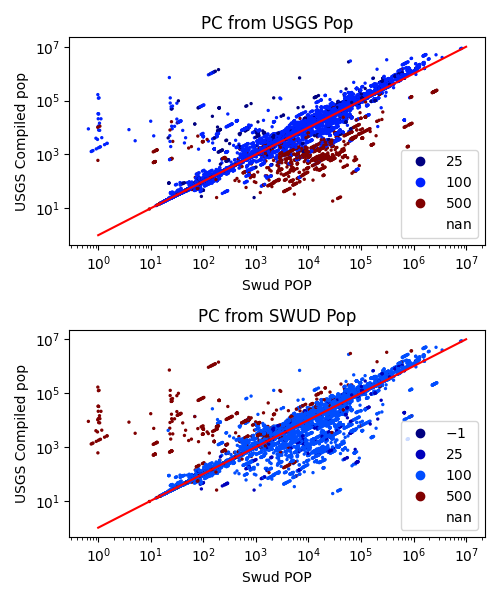

In [13]:
fig, axs = plt.subplots(2, figsize=(5, 6))
pop_info_ = pop_info[pop_info['wu_rate']>0]

# plot swud vs tpop
suwd_pc = pop_info_['wu_rate']/pop_info_['TPOPSRV']
swud_pc = inf_to_nan(suwd_pc)
pc_flg = suwd_pc.copy() * 0 
pc_flg[swud_pc>500] = 500
pc_flg[swud_pc<25] = 25
pc_flg[swud_pc.isna()] = -1
pc_flg[pc_flg==0] = 100
scatter = axs[0].scatter(pop_info_['pop_swud15'], pop_info_['TPOPSRV'], s = 2, c = pc_flg, cmap = 'jet')
axs[0].plot([1,1e7], [1,1e7], 'r')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel("Swud POP")
axs[0].set_ylabel("USGS Compiled pop")
axs[0].set_title("PC from USGS Pop")
axs[0].legend(*scatter.legend_elements())



pop_info_ = pop_info[pop_info['wu_rate']>0]
suwd_pc = pop_info_['wu_rate']/pop_info_['pop_swud15']
swud_pc = inf_to_nan(suwd_pc)
pc_flg = suwd_pc.copy() * 0 
pc_flg[swud_pc>500] = 500
pc_flg[swud_pc<25] = 25
pc_flg[swud_pc.isna()] = -1
pc_flg[pc_flg==0] = 100
scatter = axs[1].scatter(pop_info_['pop_swud15'], pop_info_['TPOPSRV'], s = 2, c = pc_flg, cmap = 'jet')
plt.plot([1,1e7], [1,1e7], 'r')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel("Swud POP")
plt.ylabel("USGS Compiled pop")
axs[1].set_title("PC from SWUD Pop")
axs[1].legend(*scatter.legend_elements())
plt.tight_layout()
plt.show()



- When place pop is compared with SWUD, we can see that some of Place population might be small resulting in large per capita. 
- It seems that SWUD data generally produces reasonable PC values. However, in general place pop and swud looks close to each other

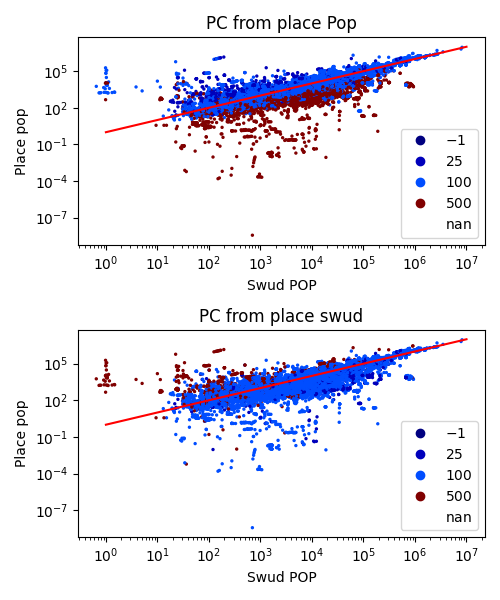

In [14]:
fig, axs = plt.subplots(2, figsize=(5, 6))
pop_info_ = pop_info[pop_info['wu_rate']>0]

# plot swud vs place pop
suwd_pc = pop_info_['wu_rate']/pop_info_['plc_pop_interpolated']
swud_pc = inf_to_nan(suwd_pc)
pc_flg = suwd_pc.copy() * 0 
pc_flg[swud_pc>500] = 500
pc_flg[swud_pc<25] = 25
pc_flg[swud_pc.isna()] = -1
pc_flg[pc_flg==0] = 100
scatter = axs[0].scatter(pop_info_['pop_swud15'], pop_info_['plc_pop_interpolated'], s = 2, c = pc_flg, cmap = 'jet')
axs[0].plot([1,1e7], [1,1e7], 'r')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel("Swud POP")
axs[0].set_ylabel("Place pop")
axs[0].set_title("PC from place Pop")
axs[0].legend(*scatter.legend_elements())

# plot swud vs place pop
suwd_pc = pop_info_['wu_rate']/pop_info_['pop_swud15']
swud_pc = inf_to_nan(suwd_pc)
pc_flg = suwd_pc.copy() * 0 
pc_flg[swud_pc>500] = 500
pc_flg[swud_pc<25] = 25
pc_flg[swud_pc.isna()] = -1
pc_flg[pc_flg==0] = 100
scatter = axs[1].scatter(pop_info_['pop_swud15'], pop_info_['plc_pop_interpolated'], s = 2, c = pc_flg, cmap = 'jet')
axs[1].plot([1,1e7], [1,1e7], 'r')
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel("Swud POP")
axs[1].set_ylabel("Place pop")
axs[1].set_title("PC from place swud")
axs[1].legend(*scatter.legend_elements())

plt.tight_layout()

* When Zillow nhouses is very small (<10 houses) and SWUD pop is large, this very strong indicator of service area issue
* From SWUD pop, people per house is about 2.69. Extrem values for SWUD population (with good PC values) likely means service area problem

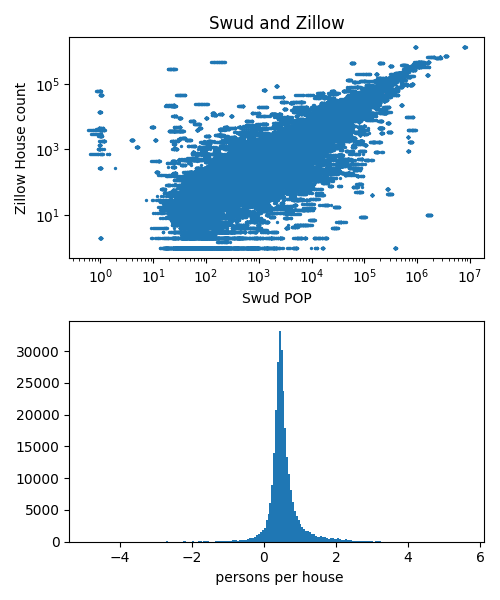

In [15]:
fig, axs = plt.subplots(2, figsize=(5, 6))
axs[0].scatter(pop_info['pop_swud15'], pop_info['zillow_nh'], s = 2)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel("Swud POP")
axs[0].set_ylabel("Zillow House count")
axs[0].set_title("Swud and Zillow")
persons_per_house = pop_info['pop_swud15']/pop_info['zillow_nh']
persons_per_house = inf_to_nan(persons_per_house)
persons_per_house = persons_per_house[persons_per_house>0]
axs[1].hist(np.log10(persons_per_house), bins = 200)
axs[1].set_xlabel(" persons per house")
plt.tight_layout()
plt.show()

C:\Miniconda3\envs\py39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


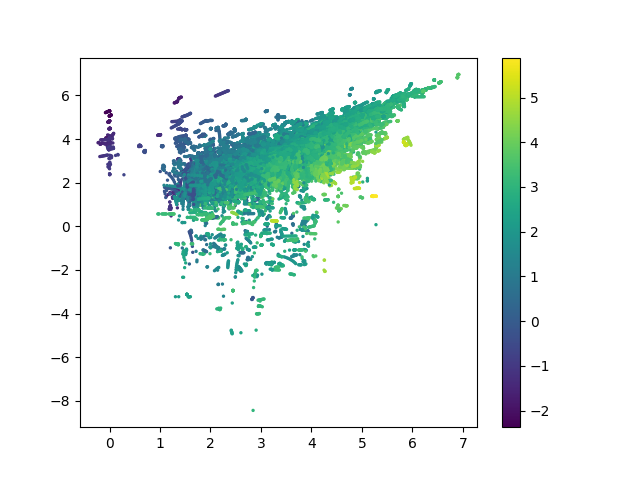

In [16]:
plt.figure()
v = pop_info['pop_swud15'] / pop_info['WSA_SQKM']
v[v.isna()] = 1
plt.scatter(np.log10(pop_info['pop_swud15']), 
            np.log10(pop_info['plc_pop_interpolated']),
            s = 2,
            c=np.log10(v))
plt.colorbar()
plt.show()

In [19]:
# per capita water use
pop_info['pc_tract'] = pop_info['wu_rate'] / pop_info['tract_pop']
pop_info['pc_plc'] = pop_info['wu_rate'] / pop_info['plc_pop_interpolated']
pop_info['pc_tpop'] = pop_info['wu_rate'] / pop_info['TPOPSRV']

# per house population
pop_info['pz_tract'] = pop_info['tract_pop'] / pop_info['zillow_nh']
pop_info['pz_plc'] = pop_info['plc_pop_interpolated'] / pop_info['zillow_nh']
pop_info['pz_tpop'] = pop_info['TPOPSRV'] / pop_info['zillow_nh']

# per building population
pop_info['pf_tract'] = pop_info['tract_pop'] / pop_info['bdg_ftp_count']
pop_info['pf_plc'] = pop_info['plc_pop_interpolated'] / pop_info['bdg_ftp_count']
pop_info['pf_tpop'] = pop_info['TPOPSRV'] / pop_info['bdg_ftp_count']

In [20]:
pc_columns = [c for c in pop_info.columns if ("pc_" in c or "pz_" in c or "pf_" in c)]
for c in pc_columns:
    pop_info[c] = np.log10(pop_info[c])
pop_info.replace([np.inf, -np.inf], np.nan, inplace=True)


C:\Miniconda3\envs\py39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


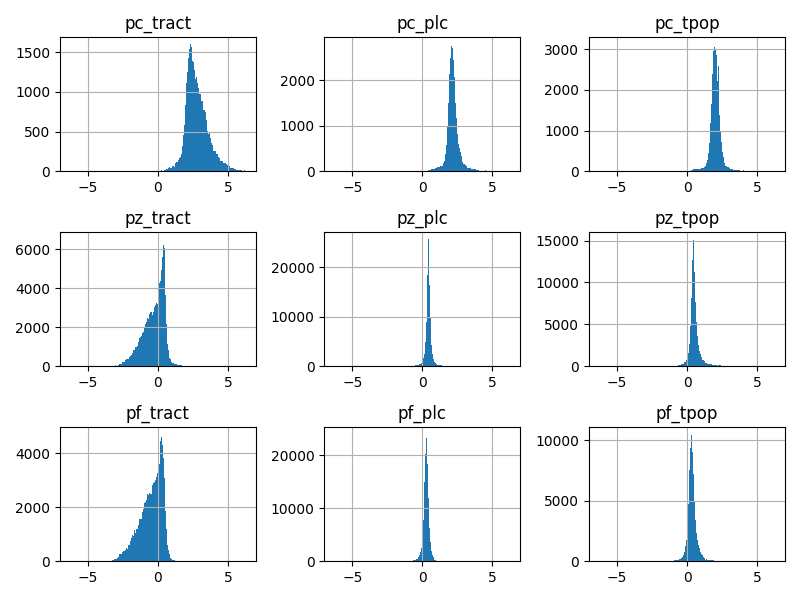

In [21]:
f, axs = plt.subplots(3, 3, figsize=(8, 6))
col_iter = iter(pc_columns)
for ax in axs.reshape(-1):
    curr_col = next(col_iter)
    pop_info[curr_col].hist(ax=ax, bins=500);
    ax.set_title(curr_col)
    ax.set_xlim([-7, 7])
plt.tight_layout()

In [ ]:
df_pc = pop_info[pc_columns]
np.power(10, df_pc).describe()

In [ ]:
plt.figure()
pop_info['pc_tract'].hist(bins=500, alpha=0.5, label='Census Tract');
pop_info['pc_plc'].hist(bins=500, alpha=0.5, label='Census Place');
pop_info['pc_tpop'].hist(bins=500, alpha=0.5, label='Tpop');
plt.legend()
plt.title("Per Capita Water Use")

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(10, 6))

pop_info['pz_plc'].hist(ax=axs[0], bins=500, alpha=0.5, label='Zillow - Census Place');
pop_info['pz_tpop'].hist(ax=axs[0], bins=500, alpha=0.5, label='Zillow - Tpop');
axs[0].legend()
axs[0].set_xlim([-2, 3])
axs[0].set_ylim([0, 40000])
pop_info['pf_plc'].hist(ax=axs[1], bins=500, alpha=0.5, label='MS Footprint - Census Place');
pop_info['pf_tpop'].hist(ax=axs[1], bins=500, alpha=0.5, label='MS Footprint -Tpop');
axs[1].set_xlim([-2, 3])
axs[1].set_ylim([0, 40000])
plt.legend()
plt.title("People per building")

In [ ]:
var = 'state_id'
f, ax = plt.subplots(figsize=(8, 6))
df_main['family_size'] = df_main['population'] / df_main['households2']
df__ = df_main[df_main['population'] > 15000]
fig = sns.boxplot(x=var, y='family_size', data=df__)
ax.set_yscale('log');
plt.xticks(rotation=90);
ax.set_ylim([0, 6])

# Typical Per_capita water use

In [ ]:
from shapely.geometry import Point, Polygon

pc_xy_tpop = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_tpopsrv.csv")
pc_xy_tpop_old = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50.csv")

pc_xy_tpop = geopandas.GeoDataFrame(
    pc_xy_tpop, geometry=geopandas.points_from_xy(pc_xy_tpop.x, pc_xy_tpop.y), crs="EPSG:5070")
pc_xy_tpop = pc_xy_tpop.to_crs(epsg=4326)

In [ ]:
geo_data = GeoData(geo_dataframe=pc_xy_tpop,
                   style={'color': 'black', 'radius': 8, 'fillColor': '#3366cc', 'opacity': 0.5, 'weight': 1.9,
                          'dashArray': '2', 'fillOpacity': 0.6},
                   hover_style={'fillColor': 'red', 'fillOpacity': 0.2},
                   point_style={'radius': 1, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
                   name='Release')

In [ ]:

m = Map(center=(40, -100), zoom=3, basemap=basemaps.OpenStreetMap)
# m.add_layer(geo_data)
m

In [ ]:
pc_xy_tpop.plot(column='pc_median', markersize=1, cmap='jet', legend=True)

In [ ]:
plt.figure()
plt.scatter(pc_xy_tpop_old['x'], pc_xy_tpop_old['y'], c=pc_xy_tpop_old['pc_median'], s=1, cmap='jet')
plt.colorbar()
pc_xy_tpop = pc_xy_tpop_old

In [ ]:
# merge per capita map with pop_info layer
pop_info = pop_info.merge(pc_xy_tpop[['sys_id', 'x', 'y', 'pc_median']], how='left', right_on='sys_id',
                          left_on='sys_id')

In [ ]:
pop_info

In [ ]:
pop_info['diff_pc_tract'] = np.log10(np.abs(np.power(10, pop_info['pc_tract']) - pop_info['pc_median']))
pop_info['diff_pc_plc'] = np.log10(np.abs(np.power(10, pop_info['pc_plc']) - pop_info['pc_median']))
pop_info['diff_pc_tpop'] = np.log10(np.abs(np.power(10, pop_info['pc_tpop']) - pop_info['pc_median']))

pop_info['diff_pz_tract'] = np.log10(np.abs(np.power(10, pop_info['pz_tract']) - 2.75))
pop_info['diff_pz_plc'] = np.log10(np.abs(np.power(10, pop_info['pz_plc']) - 2.75))
pop_info['diff_pz_tpop'] = np.log10(np.abs(np.power(10, pop_info['pz_tpop']) - 2.75))

pop_info['diff_pf_tract'] = np.log10(np.abs(np.power(10, pop_info['pf_tract']) - 2.15))
pop_info['diff_pf_plc'] = np.log10(np.abs(np.power(10, pop_info['pf_plc']) - 2.15))
pop_info['diff_pf_tpop'] = np.log10(np.abs(np.power(10, pop_info['pf_tpop']) - 2.15))

pop_info.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
plt.figure()
pop_info['diff_pc_tract'].hist(bins=500, density=True, label='tract data')
pop_info['diff_pc_plc'].hist(bins=500, alpha=0.5, density=True, label='Place Data')
pop_info['diff_pc_tpop'].hist(bins=500, alpha=0.5, density=True, label='tpop Data')
plt.xlim([-2, 6])
plt.xlabel("Log10 of difference between actual PC water use and typical water use")
plt.legend()

In [ ]:
# find best population
diff_pc = ['diff_pc_tract', 'diff_pc_plc', 'diff_pc_tpop']
diff_pz = ['diff_pz_tract', 'diff_pz_plc', 'diff_pz_tpop']
diff_pf = ['diff_pf_tract', 'diff_pf_plc', 'diff_pf_tpop']

pop_info['pop'] = 0
# systems with water use
best_pop_col = pop_info[diff_pc].idxmin(axis=1)
pop_pc_map = {'diff_pc_tract': 'tract_pop', 'diff_pc_plc': 'plc_pop_interpolated', 'diff_pc_tpop': 'tpop_srv'}
for f in ['diff_pc_tract', 'diff_pc_plc', 'diff_pc_tpop']:
    mask = best_pop_col == f
    pp_field = pop_pc_map[f]
    curr_syss = pop_info[mask]['sys_id'].unique()
    mask2 = pop_info['sys_id'].isin(curr_syss)
    pop_info.loc[mask2, 'pop'] = pop_info.loc[mask2, pp_field]


In [ ]:
plt.figure()
plt.scatter(pop_info['pop'], pop_info['wu_rate'], s=1)
# plt.plot(pop_info['pop'], 100*pop_info['pop'], c= 'r')
plt.yscale('log');
plt.xscale('log')
plt.xlabel('Population')
plt.ylabel('Water use')

## Percent of systems without WU data

In [ ]:
#  a list of bad(??) population by comparing tpop and tract pop??

In [ ]:
np.sum(pop_info['pop'] > 0) / len(pop_info)

In [ ]:
mask_2019 = (pop_info['pop'] == 0) & (pop_info['year'] == 2019)
pop2019 = pop_info[mask_2019]
plt.figure()
pop2019['pz_tpop'].hist(bins=50)

In [ ]:
pz95 = pop_info['pz_plc'].quantile(0.95)
pz05 = pop_info['pz_plc'].quantile(0.05)
pf95 = pop_info['pf_plc'].quantile(0.95)
pf05 = pop_info['pf_plc'].quantile(0.05)
hpop = pop2019[(pop2019['pz_tpop'] >= pz95) & (pop2019['pz_plc'] >= pz95)]
lpop = pop2019[(pop2019['pz_tpop'] <= pz05) & (pop2019['pz_plc'] <= pz05)]
s1 = set(hpop['sys_id'].values).union(lpop['sys_id'].values)

hpop = pop2019[(pop2019['pf_tpop'] >= pf95) & (pop2019['pf_plc'] >= pf95)]
lpop = pop2019[(pop2019['pf_tpop'] <= pf05) & (pop2019['pf_plc'] <= pf05)]
s2 = set(hpop['sys_id'].values).union(lpop['sys_id'].values)

house_count_off_sys = s1.intersection(s2)

In [ ]:
mask = (pop_info['sys_id'].isin(house_count_off_sys)) & (pop_info['bdg_ftp_count'] > 0)
person_per_building = 10 ** pop_info['pf_plc'].quantile(0.5)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'bdg_ftp_count'] * person_per_building

In [ ]:
pop_info.loc[mask, 'pop']

In [ ]:
pop_info

In [ ]:
np.sum(pop_info['pop'] > 0) / len(pop_info)

In [ ]:
mask = (pop_info['pop'] == 0) & (pop_info['plc_pop_interpolated'] > 0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'plc_pop_interpolated']
pop_info[mask]

In [ ]:
np.sum(pop_info['pop'] > 0) / len(pop_info)

In [ ]:
mask = (pop_info['pop'] == 0) & (pop_info['tpop_srv'] > 0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'tpop_srv']
pop_info[mask]

In [ ]:
np.sum(pop_info['pop'] > 0) / len(pop_info)

In [ ]:
mask = (pop_info['pop'] == 0) & (pop_info['bdg_ftp_count'] > 0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'bdg_ftp_count'] * 1.8
pop_info[mask]

In [ ]:
np.sum(pop_info['pop'] > 0) / len(pop_info)

In [ ]:
mask = (pop_info['pop'] == 0) & (pop_info['tract_pop'] > 0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'tract_pop']
pop_info[mask]

In [ ]:
np.sum(pop_info['pop'] > 0) / len(pop_info)

In [ ]:
pop_info.to_csv("pop_info.csv")